# Verification of Quantum Circuits

Compiling quantum algorithms results in different representations of the considered functionality, which significantly differ in their basis operations and structure but are still supposed to be functionally equivalent.
As described in the previous section, even individual compilation tasks can be highly complex.
Consequently, checking whether the original functionality is indeed maintained throughout all these different abstractions becomes increasingly relevant in order to guarantee a consistent and error-free compilation flow.
This is similar to the classical realm, where descriptions at various levels of abstraction also exist.
These descriptions are verified using design automation expertise---resulting in efficient methods for verification to ensure the correctness of the design across different levels of abstraction.
However, since quantum circuits additionally employ quantum-physical effects such as superposition and entanglement, these methods cannot be used out of the box in the quantum realm.
Accordingly, verification of quantum circuits must be approached from a different perspective.
At first glance, these characteristics of quantum computing make verification much harder as for classical circuits and systems.
In fact, equivalence checking of quantum circuits has been proven to be a computationally hard problem.

At the same time, quantum circuits possess certain characteristics that offer remarkable potential for efficient equivalence checking that is not available in classical computing.
More precisely, consider two quantum circuits $G=g_1,\dots,g_m$ and $G'=g'_1,\dots,g'_n$ whose equivalence shall be checked.
Due to the inherent reversibility of quantum operations, the inverse of a quantum circuit can easily be computed by taking the complex conjugate of every gate and reversing the sequence of the gates in the circuit, i.e., $G^{\prime -1}= (g'_n)^\dagger,\dots,(g'_1)^\dagger$.
If two circuits are equivalent, this allows for the conclusion that $G\cdot G^{\prime -1} = I$, where $I$ is the identity function.
Since the identity has the most compact representation for most data structures representing quantum functionality (e.g., linear with respect to the number of qubits in case of decision diagrams), the equivalence check can be simplified considerably.
Even complex circuits can be verified efficiently, if one manages to apply the gates of both circuits in a sequence that keeps the intermediate representation "close to the identity".
Within the MQT, several methods and strategies were proposed that utilize this characteristic of quantum computations.
Eventually, this led to solutions that can verify the results of whole quantum compilation flows (such as IBM's Qiskit) in negligible runtime---something we never even managed for classical circuits and systems.

The _MQT_ offers the quantum circuit equivalence checking tool QCEC which encompasses a comprehensive suite of efficient methods and automated tools for the verification of quantum circuits.
By this, an important step towards avoiding or substantially mitigating the emerge of a verification gap for quantum circuits is taken, i.e., a situation where the physical development of a technology substantially outperforms our ability to design suitable applications for it or to verify it.


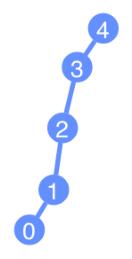

In [1]:
from mqt.bench import get_benchmark, BenchmarkLevel
from qiskit.transpiler import CouplingMap
from qiskit.visualization import plot_gate_map
from qiskit.providers.fake_provider import GenericBackendV2

# Create a 5-qubit device with linear connectivity
num_qubits = 5
coupling_map = CouplingMap.from_line(num_qubits=num_qubits)
backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map, basis_gates=["cx", "u"])

# Visualize the device
plot_gate_map(backend)

## Setup: Create a Device and Load a Circuit

Let's start with a 5-qubit device and a quantum circuit to verify:

## Compare Original and Compiled Circuits

Let's load a Quantum Fourier Transform (QFT) circuit and compile it:

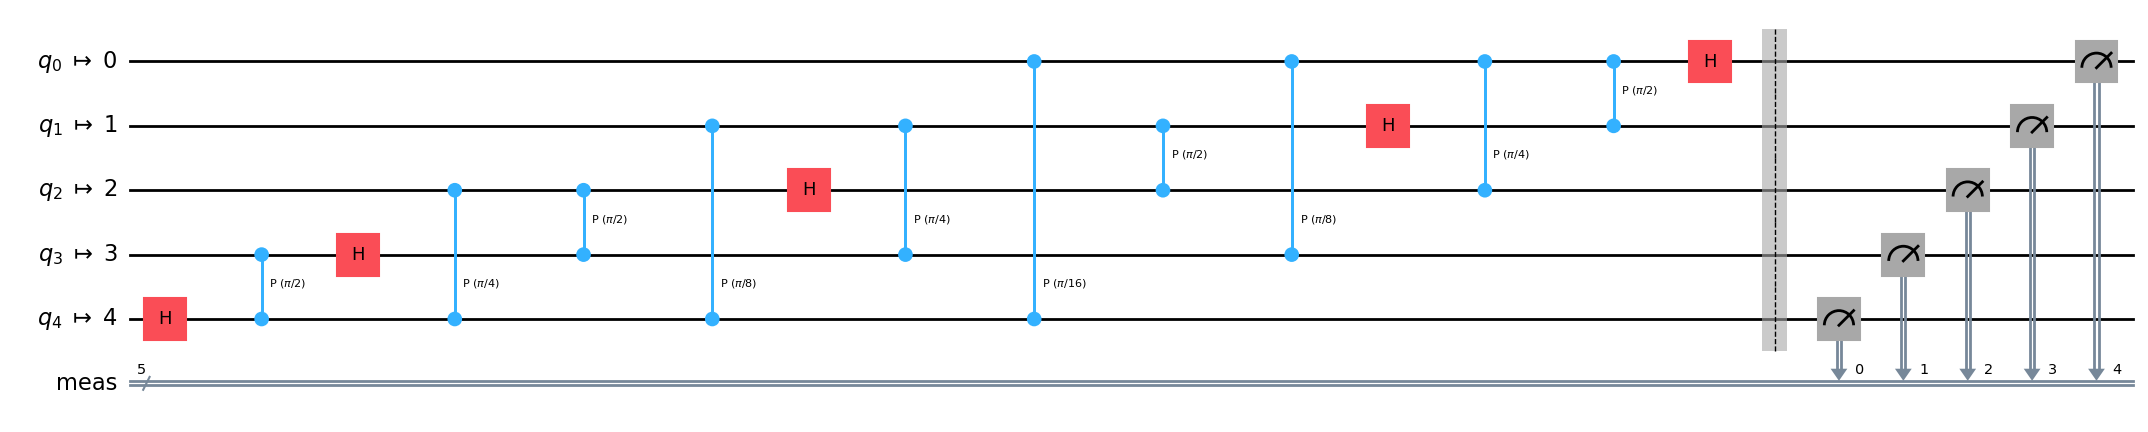

In [2]:
# Load a 5-qubit QFT circuit (platform-independent level)
circ = get_benchmark(benchmark="qft", level=BenchmarkLevel.INDEP, circuit_size=5)
circ.draw(output='mpl', fold=-1)

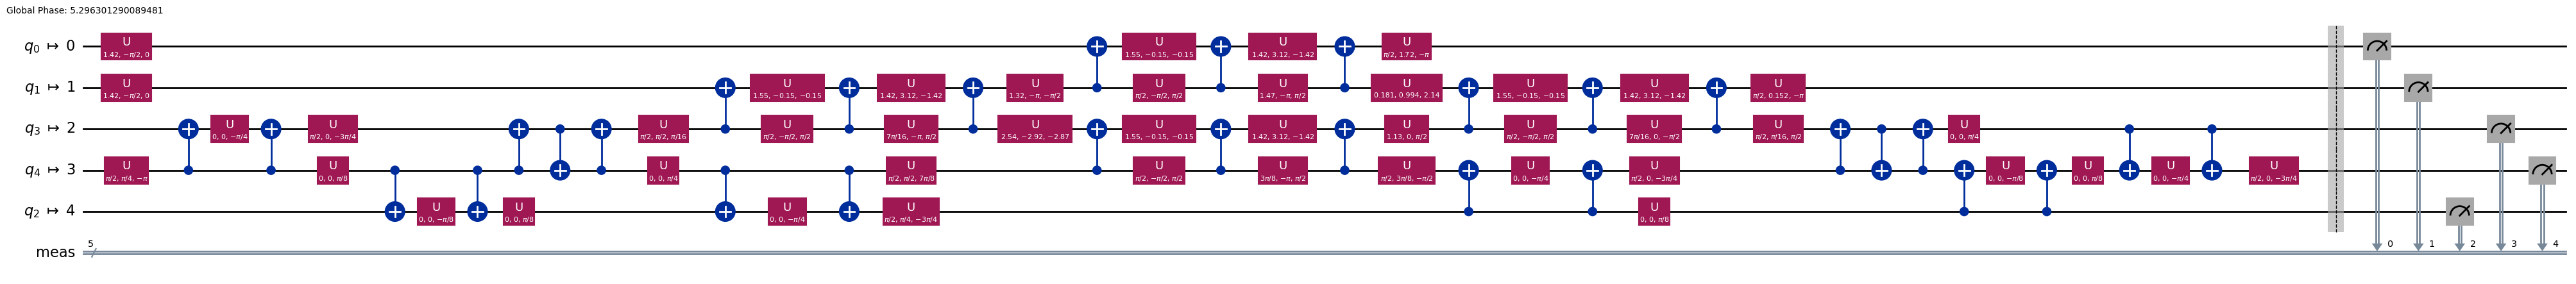

In [3]:
from qiskit import transpile

# Compile the circuit to the device
circ_mapped = transpile(circ, backend=backend)
circ_mapped.draw(output='mpl', fold=-1)

## Examine the Underlying Matrices

Both circuits should implement the same unitary transformation. Let's check their matrix representations:

In [4]:
from qiskit.quantum_info import Operator

# Extract the unitary matrix from the original circuit
op_initial = Operator.from_circuit(circ.remove_final_measurements(inplace=False))
print("Original circuit unitary matrix:")
print(op_initial.to_matrix())

Original circuit unitary matrix:
[[ 0.1767767 +0.j          0.1767767 +0.j          0.1767767 +0.j
  ...  0.1767767 +0.j          0.1767767 +0.j
   0.1767767 +0.j        ]
 [ 0.1767767 +0.j          0.17337998+0.03448742j  0.16332037+0.06764951j
  ...  0.14698445-0.09821187j  0.16332037-0.06764951j
   0.17337998-0.03448742j]
 [ 0.1767767 +0.j          0.16332037+0.06764951j  0.125     +0.125j
  ...  0.06764951-0.16332037j  0.125     -0.125j
   0.16332037-0.06764951j]
 ...
 [ 0.1767767 +0.j          0.14698445-0.09821187j  0.06764951-0.16332037j
  ... -0.03448742+0.17337998j  0.06764951+0.16332037j
   0.14698445+0.09821187j]
 [ 0.1767767 +0.j          0.16332037-0.06764951j  0.125     -0.125j
  ...  0.06764951+0.16332037j  0.125     +0.125j
   0.16332037+0.06764951j]
 [ 0.1767767 +0.j          0.17337998-0.03448742j  0.16332037-0.06764951j
  ...  0.14698445+0.09821187j  0.16332037+0.06764951j
   0.17337998+0.03448742j]]


/Users/patrickhopf/Code/mqt/.github/tutorial/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:4625: UserWarning: Trying to add QuantumRegister to a QuantumCircuit having a layout
  circ.add_register(qreg)


In [5]:
# Extract the unitary matrix from the compiled circuit
op_mapped = Operator.from_circuit(circ_mapped.remove_final_measurements(inplace=False))
print("Compiled circuit unitary matrix:")
print(op_mapped.to_matrix())

Compiled circuit unitary matrix:
[[ 1.76776695e-01+1.28255910e-16j  1.76776695e-01+1.75867939e-16j
   1.76776695e-01-8.35333446e-17j ...  1.76776695e-01+5.98640394e-17j
   1.76776695e-01-2.47047665e-16j  1.76776695e-01-2.62752060e-16j]
 [ 1.76776695e-01+3.83250774e-16j -1.76776695e-01-3.06487319e-16j
   1.76776695e-01-9.31020570e-17j ... -1.76776695e-01-5.33513520e-16j
   1.76776695e-01+1.58873759e-17j -1.76776695e-01-5.12179273e-17j]
 [ 1.76776695e-01+2.34679997e-16j  4.73599719e-17+1.76776695e-01j
  -1.76776695e-01-2.03522692e-16j ... -4.15990803e-16+1.76776695e-01j
  -1.76776695e-01-1.30254230e-16j  1.04183076e-16-1.76776695e-01j]
 ...
 [ 1.76776695e-01+4.52905663e-16j -3.44874224e-02-1.73379981e-01j
  -1.63320371e-01+6.76495125e-02j ...  9.82118698e-02-1.46984450e-01j
  -1.63320371e-01-6.76495125e-02j -3.44874224e-02+1.73379981e-01j]
 [ 1.76776695e-01+5.02307578e-16j -1.73379981e-01+3.44874224e-02j
   1.63320371e-01-6.76495125e-02j ... -1.46984450e-01-9.82118698e-02j
   1.63320371e

## Verification Method 1: Using Qiskit

Qiskit can compare operators by constructing their full matrix representations:

In [6]:
# Check equivalence using Qiskit's built-in method
result = op_initial.equiv(op_mapped)
print(f"Circuits are equivalent: {result}")

Circuits are equivalent: False


## Verification Method 2: Using MQT QCEC

MQT QCEC uses decision diagrams and exploits reversibility for efficient verification:

In [7]:
from mqt.qcec import verify

# Verify equivalence using MQT QCEC
result = verify(circ, circ_mapped)
print(f"Circuits are equivalent: {result.considered_equivalent()}")
print(f"Equivalence class: {result.equivalence}")

Circuits are equivalent: True
Equivalence class: EquivalenceCriterion.equivalent_up_to_global_phase


## Performance Comparison: QCEC vs Qiskit

Let's benchmark both verification methods on QFT circuits of increasing size:

In [8]:
import time

times_MQT_QCEC = []
times_qiskit = []
qubit_range = range(2, 12)

for i in qubit_range:
    print(f"Verifying {i}-qubit QFT circuit...")
    
    # Load and compile circuit
    circ = get_benchmark(benchmark="qft", level=BenchmarkLevel.ALG, circuit_size=i)
    backend = GenericBackendV2(num_qubits=i, coupling_map=CouplingMap.from_line(i), 
                               basis_gates=["cx", "rz", "sx", "x"])
    circ_mapped = transpile(circ, backend=backend)
    
    # Measure MQT QCEC verification time
    start_time = time.time()
    assert verify(circ, circ_mapped).considered_equivalent()
    times_MQT_QCEC.append(time.time() - start_time)
    print(f"  MQT QCEC: {times_MQT_QCEC[-1]:.6f}s")

    # Measure Qiskit verification time
    start_time = time.time()
    op_initial = Operator.from_circuit(circ.remove_final_measurements(inplace=False))
    op_mapped = Operator.from_circuit(circ_mapped.remove_final_measurements(inplace=False))
    assert op_initial.equiv(op_mapped)
    times_qiskit.append(time.time() - start_time)
    print(f"  Qiskit: {times_qiskit[-1]:.6f}s")
    
print("\nBenchmark complete!")

Verifying 2-qubit QFT circuit...
  MQT QCEC: 0.006712s
  Qiskit: 0.003225s
Verifying 3-qubit QFT circuit...
  MQT QCEC: 0.004704s
  Qiskit: 0.001533s
Verifying 4-qubit QFT circuit...
  MQT QCEC: 0.003729s
  Qiskit: 0.002357s
Verifying 5-qubit QFT circuit...
  MQT QCEC: 0.003954s
  Qiskit: 0.004763s
Verifying 6-qubit QFT circuit...
  MQT QCEC: 0.004553s
  Qiskit: 0.010564s
Verifying 7-qubit QFT circuit...
  MQT QCEC: 0.007453s
  Qiskit: 0.044511s
Verifying 8-qubit QFT circuit...
  MQT QCEC: 0.014649s
  Qiskit: 0.044511s
Verifying 8-qubit QFT circuit...
  MQT QCEC: 0.014649s
  Qiskit: 0.183499s
Verifying 9-qubit QFT circuit...
  MQT QCEC: 0.033865s
  Qiskit: 0.183499s
Verifying 9-qubit QFT circuit...
  MQT QCEC: 0.033865s
  Qiskit: 0.938170s
Verifying 10-qubit QFT circuit...
  MQT QCEC: 0.033987s
  Qiskit: 0.938170s
Verifying 10-qubit QFT circuit...
  MQT QCEC: 0.033987s
  Qiskit: 5.221535s
Verifying 11-qubit QFT circuit...
  MQT QCEC: 0.166332s
  Qiskit: 5.221535s
Verifying 11-qubit QFT

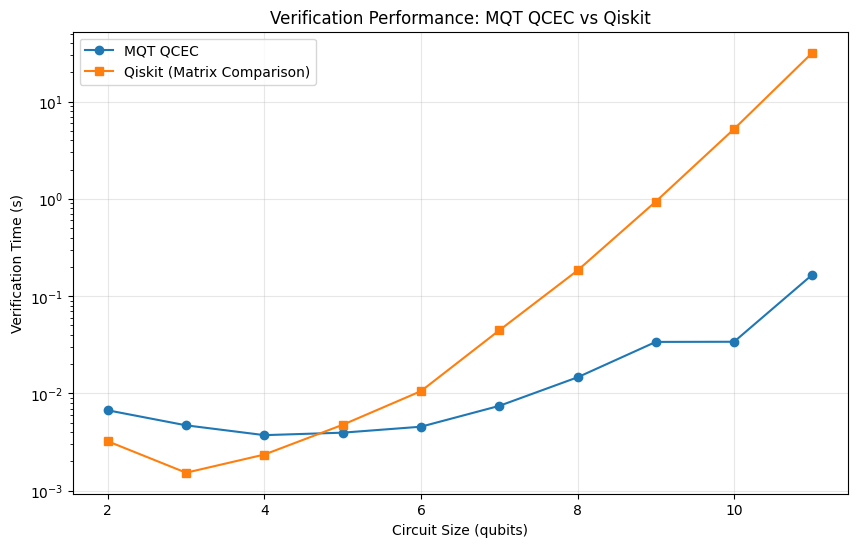


For 11-qubit circuits:
MQT QCEC is 190.8x faster than Qiskit


In [9]:
import matplotlib.pyplot as plt

# Plot verification time comparison
plt.figure(figsize=(10, 6))
plt.xlabel("Circuit Size (qubits)")
plt.ylabel("Verification Time (s)")
plt.title("Verification Performance: MQT QCEC vs Qiskit")
plt.plot(qubit_range, times_MQT_QCEC, marker='o', label="MQT QCEC")
plt.plot(qubit_range, times_qiskit, marker='s', label="Qiskit (Matrix Comparison)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better show the difference
plt.show()

# Print speedup factor
print(f"\nFor {max(qubit_range)}-qubit circuits:")
print(f"MQT QCEC is {times_qiskit[-1]/times_MQT_QCEC[-1]:.1f}x faster than Qiskit")

## Exercises for Further Exploration

Try extending this tutorial with:

1. **Different Algorithms**: Verify other circuits from MQT Bench (e.g., `grover`, `shor`, `qaoa`)
   - See: https://mqt.readthedocs.io/projects/bench/en/latest/Benchmark_selection.html

2. **Different Compilers**: Compare verification of circuits compiled with:
   - Qiskit's different optimization levels (0-3)
   - MQT QMAP vs Qiskit transpiler

3. **Advanced QCEC Features**: Explore different verification strategies
   - See: https://mqt.readthedocs.io/projects/qcec/en/latest/

4. **Error Injection**: Intentionally modify compiled circuits and verify QCEC catches non-equivalence